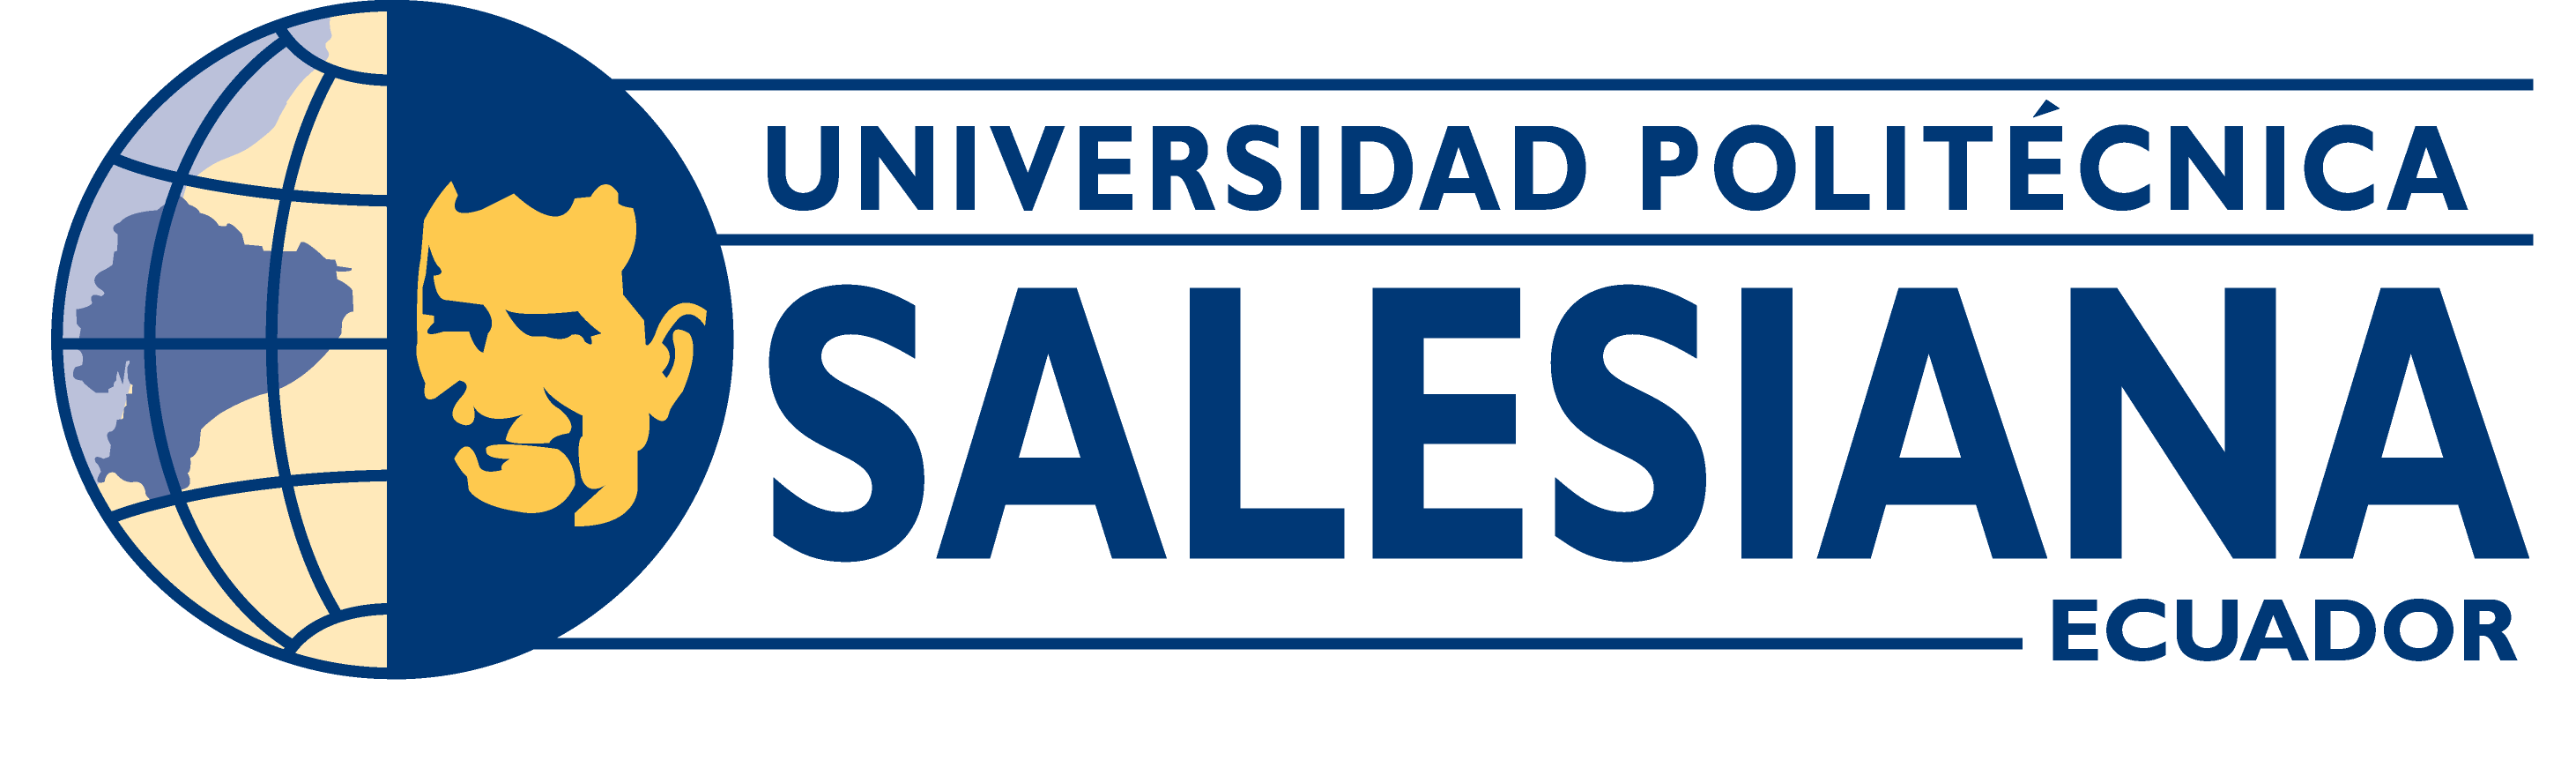

### Names: Jose Illescas, Oscar Mora
### Group: 1
### Number Recognition

## Intercycle project

This project consists of the creation of a neural network layers to identify which number was drawn by a user in the drawing panel created in python for this project.

In this project, digit recognition is performed through the training of a neural network which uses a data corpus provided for the most efficient use of the neural network.


##  Corpus reading for training the Neural network

In the following code we can see how the corpus of data is called for the training of the network, this corpus is set up in the following way.

The digits of the corpus are created in a matrix of 32 columns as well as 32 rows, the matrix is composed of a group of 0 where these are considered edges of the number.

While the numbers 1 inside the matrix simulate the number drawn as shown in the following matrix.

00000000000000000000000000000000
00000000000001111000000000000000
00000000000011111000000000000000
00000000000111111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000000111000000000000000
00000000000111111111000000000000
00000000000111111111000000000000
00000000000000000000000000000000
00000000000000000000000000000000





In the following code the data corpus is called for data recognition.

In [6]:
import re
import itertools

class Utilities:
    
    def __init__(self, path = '/home/antony/Descargas/ejemploCuaderno1/corpus/digits-database.data'):
        self.path = path
        self.regex = re.compile('(0|1){2,}') # Busca patrones que coincidan con 2 o mas ceros o unos.
        self.regexno = re.compile('(\s)+[0-9]{1}') # Busca un unico numero el cual tenga un espacio o tabulacion antes del mismo.
        
    
    def generate_indices(self):
        _dict = []
        with open(self.path, 'r') as _f:
            pivote = 0
            flag = False
            lineno = 0
            for line in _f:
                if self.regex.match(line)!=None and not flag:
                    pivote = lineno
                    flag = True
                if self.regexno.match(line)!=None and flag:
                    _dict.append((int(line.replace(' ','')),pivote,lineno))
                    flag = False
                lineno += 1
            _f.close()
            
        return _dict

    def get_digit(self,_slice, _end):
        data = []
        with open(self.path, 'r') as _f:
            for line in itertools.islice(_f, _slice, _end):
                data.append([int(i) for i in line.lstrip().rstrip()])
            
            _f.close()
        return data


##  The following code shows the obtaining of indices of the number belonging to the corpus.

In this part you get the number indices for the comparison through the neural network.

In [7]:
import numpy as np

class Converter:

	def __init__(self, lim = 946):
		self.utilities = Utilities()
		self.lim = lim
		self.indices = self.utilities.generate_indices()
		self.n = []
		self.inicioFin = []
		self.datos = []
		self.delta = []

	def formater(self):
		for j, k, l in self.indices:
			self.n.append(j)
			self.inicioFin.append((k,l))

		for i in range(0, self.lim):
			inicio, fin = self.inicioFin[i]
			fila = np.ravel(np.matrix(self.utilities.get_digit(inicio, fin)))
			self.datos.append(fila)
			self.delta.append(self.n[i])
		return (self.datos, self.delta)
		
	def getIndices(self):
		return self.indices


## The following code shows the creation of the neural network

In this part the division of the data is carried out in a percentage of 80 and 20 percent of the data which are divided for train and test, which improves the training of the neural network.

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np

class Red:

	def __init__(self, lim = 946, iteraciones = 500):
		self.converter = Converter(lim)
		self.indices = self.converter.getIndices()
		self.data = self.converter.formater()
		self.label_encoder = LabelEncoder()
		self.datos, self.delta = self.data
		self.iteraciones = iteraciones
		self.codificar()
	
	def codificar(self):
		salida = self.label_encoder.fit_transform(self.delta)
		onehot_encoder = OneHotEncoder(sparse=False)
		salida = salida.reshape(len(salida), 1)
		self.onehot_encoded = onehot_encoder.fit_transform(salida)
	
	def entrenar(self):
		x_train, x_test, d_train, d_test = train_test_split(self.datos, self.onehot_encoded, test_size=0.80, random_state=0)
		self.mlp = MLPClassifier(solver = 'lbfgs', activation='logistic', verbose=True, alpha=1e-4, tol=1e-15, max_iter=self.iteraciones, \
		hidden_layer_sizes=(1024, 512, 256, 128, 10))
		self.mlp.fit(self.datos, self.onehot_encoded)
		
		self.predecir(self.datos[945]) #numero menos
		prediccion = (np.argmax(self.mlp.predict(x_test), axis = 1) + 1).reshape(-1, 1)
		print('Matriz de Confusion\n')
		matriz = confusion_matrix((np.argmax(d_test, axis = 1) + 1).reshape(-1, 1), prediccion)
		print(matriz)
		print('\n')
		print(classification_report((np.argmax(d_test, axis = 1) + 1).reshape(-1, 1), prediccion))

	def predecir(self, entrada):
		res = self.mlp.predict(entrada.reshape(1, -1))
		num = (np.argmax(res, axis=1)+1).reshape(-1, 1) # Decodifica el numero.
		aux = []
		matriz = []
		for i in range(32):
			for j in range(i * 32, (i + 1) * 32):
				aux.append(entrada[j])
			matriz.append(aux)
			aux = []
		for i in range(32):
			print(str(matriz[i]).replace(', ', ''))
		print(res, '=>',int(num[0] - 1))
		return int(num[0] - 1)
		
	def getIndices(self):
		return self.indices


## Creation of the frame which will contain the panel where the user can draw the number

In this part of the code, the user window is created which contains a 32 * 32 button matrix for the drawing of the same.

The window also has a checkBox in which the user can choose a number and which will be drawn on the panel automatically, This number is loaded from the existing corpus.

Once the user has selected or drawn the number we should only click on predict what will run the process of number prediction through the neural network.

In [ ]:
from tkinter import *
from tkinter import ttk
import tkinter.messagebox as msg
import numpy as np

class Ventana(Frame):

	def __init__(self, master = None):
		super().__init__(root)
		self.master = master
		self.red = Red(946, 500)#numero total de
		self.coordenadas = []
		self.indices = self.red.getIndices()
		self.utilities = Utilities()
		self.inicializar()

	def inicializar(self):
		self.master.title("IA II")
		self.master.resizable(0, 0)
		self.grid(row = 0,column = 0)
		self.matriz()

		btnEntrenar = Button(self, text="Predecir #", bg='green', fg='white', highlightbackground='#3E4149', command=self.entrenar)
		btnEntrenar.grid(columnspan = 33, sticky = W + E + N + S,row = 34, column = 0)
		
		self.cbxData = ttk.Combobox(self, values = [str(i) for i in self.indices])
		self.cbxData.grid(columnspan = 33,sticky = W + E + N + S, row = 33, column = 0)
		self.cbxData.bind('<<ComboboxSelected>>', self.cargaData)
		

	def  entrenar(self):
		self.red.entrenar()
		matriz = self.generarMatriz(32, self.coordenadas)
		numero = np.ravel(np.matrix(matriz))
		prediccion = self.red.predecir(numero)
		msg.showinfo("Resultado", "#: = " + str(prediccion))
		self.matriz()
		self.coordenadas = []

	def predecir(self):
		matriz = self.generarMatriz(32, self.coordenadas)
		numero = np.ravel(np.matrix(matriz))
		prediccion = self.red.predecir(numero)
		msg.showinfo("Resultado", "#: = " + str(prediccion))

	def matriz(self):
		self.btn = [[0 for x in range(32)] for x in range(32)] 
		for x in range(32):
			for y in range(32):
				self.btn[x][y] = Button(self,padx=8,pady=1,command=lambda x1=x, y1=y: self.seleccionar(x1,y1))
				self.btn[x][y].grid(column = x, row = y)

	def generarMatriz(self, n, coordenadas):
		matriz = []
		for i in range(n):
			matriz.append([0 for j in range(n)])

		for i in range(len(coordenadas)):
			x, y = coordenadas[i]
			matriz[y][x] = 1
		return matriz

	def seleccionar(self, x, y):
		self.btn[x][y].config(bg = "black")
		self.coordenadas.append((x, y))
		
	def reiniciar(self):
		self.matriz()
		self.coordenadas = []
		
	def cargaData(self, evt):
		self.reiniciar()
		_id = [int(i) for i in (str(self.cbxData.get()).replace(')','').replace(' ','').replace('(','')).split(',')]
		
		data = self.utilities.get_digit(_id[1],_id[2])
		for i in range(len(data)):
			for j in range(len(data[i])):
				if(data[i][j] == 1):
					self.seleccionar(j, i)

			

if __name__ == '__main__':
	root = Tk()
	ventana = Ventana(root)
	root.mainloop()


[00000000000000000110000000000000]
[00000000000011111111000000000000]
[00000000001111111111100000000000]
[00000000011111111111110000000000]
[00000000111111000001110000000000]
[00000001111100000001111000000000]
[00000001111000000001111000000000]
[00000001111000000001111000000000]
[00000001111000000001111100000000]
[00000001111000000001111111000000]
[00000001111000000011111111000000]
[00000001111000000001111100000000]
[00000001111000000111111000000000]
[00000000111100001111100000000000]
[00000000111110011111000000000000]
[00000000011111111110000000000000]
[00000000001111111110000000000000]
[00000000001111111000000000000000]
[00000000001111110000000000000000]
[00000000000111110000000000000000]
[00000000000111111000000000000000]
[00000000001111111000000000000000]
[00000000001111111000000000000000]
[00000000001111111000000000000000]
[00000000001111111100000000000000]
[00000000001111111110000000000000]
[00000000011110111110000000000000]
[00000000011110011110000000000000]
[0000000001111111111

The following image shows the result of the training of the neural network and drawing of number 1 in the drawing panel

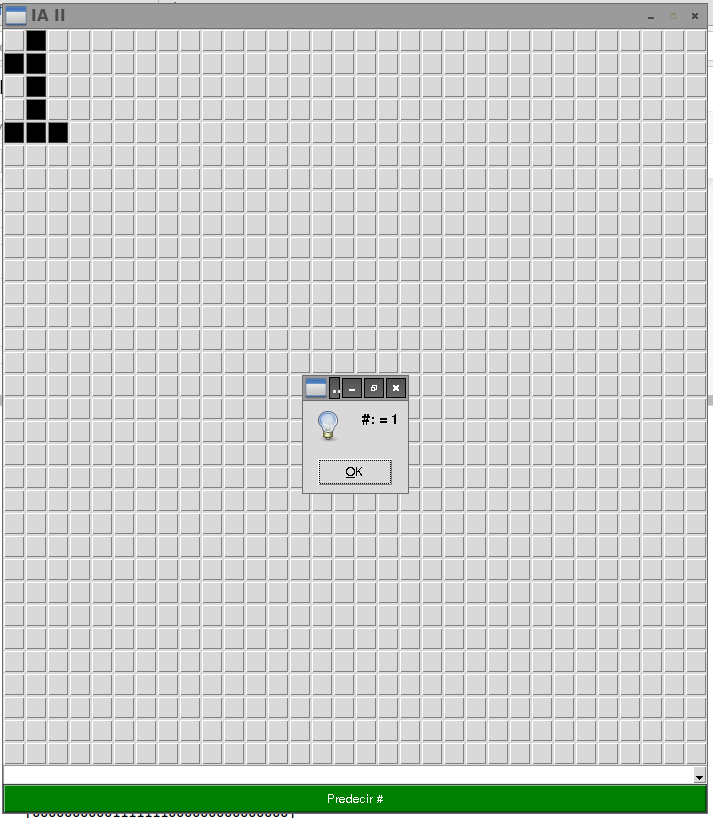

## Conclusions

* With the help of neural networks we can make almost exact predictions of the numbers drawn which is functional in the field of Artificial Intelligence.

* The theory of Artificial Neural Networks, presents great advantages with respect to other typical models of solving problems of Engineering, one of which is its inspiration in biological models of the functioning of the brain, which facilitates its study due to the analogies that can be introduced for analysis.


## Bibliography

In [ ]:
* Seijas, L., & Segura, E. C. (2003). Un clasificador neuronal que explica sus respuestas: aplicación al reconocimiento de dígitos manuscritos. In IX Congreso Argentino de Ciencias de la Computación.
* Milone, D. H. (2005). Reconocimiento automático del habla con redes neuronales artificiales. Ciencia, Docencia y Tecnología, 16(31).
* Palacios, R., & Gupta, A. (2003, May). Sistema de reconocimiento de caracteres para la lectura automática de cheques. In anales de mecánica y electricidad.
* Pérez Carrasco, J. A., Serrano Gotarredona, M. D. C., Acha Piñero, B., Serrano Gotarredona, M. T., & Linares Barranco, B. (2011). Red neuronal convolucional rápida sin fotogramas para reconocimientos de dígitos. In XXVI Simposio de la URSI (2011), p 1-4. Unión Científica Internacional de Radio.
